In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset 
import matplotlib.pyplot as plt


In [114]:
sc = MinMaxScaler(feature_range=(0,1))
pd_xela_allfiles = pd.read_csv('data.csv', index_col=0)
pd_sliplabel_allfiles = pd.read_csv('labels.csv', index_col=0)

data = pd_xela_allfiles.to_numpy()
labels = pd_sliplabel_allfiles.to_numpy()


<AxesSubplot: >

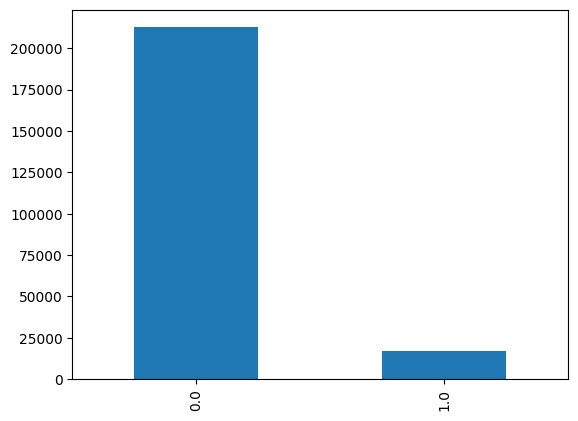

In [115]:
pd_sliplabel_allfiles.slip.value_counts().plot(kind='bar')

In [116]:
# features = pd_xela_allfiles.columns.to_list()
# features

In [117]:
data = sc.fit_transform(data)

In [118]:
(data.shape, labels.shape)

((229651, 48), (229651, 1))

In [119]:
data_prime = []
for t in range(data.shape[0]-9):
    data_prime.append(data[t:t+10])
data_prime = np.array(data_prime)
label_prime = labels[9:]

In [120]:
(data_prime.shape, 
label_prime.shape)

((229642, 10, 48), (229642, 1))

In [121]:
X_train, X_test, y_train, y_test = train_test_split(data_prime, label_prime, test_size=0.2)

In [122]:
class lsdataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        dat, lab =  self.data[idx], self.label[idx]
        return torch.Tensor(dat), torch.Tensor(lab)

train_dataset = lsdataset(X_train, y_train)
test_dataset = lsdataset(X_test, y_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

device = 'cpu'
batch_size = 32

In [123]:
# train_size = int(data.shape[0] * 0.7)
# test_size = data.shape[0] - train_size
# train_data, test_data = data[0:train_size, :], data[train_size:data.shape[0], :]

In [124]:
# class lsdataset(Dataset):
#     def __init__(self, data, seq=10):
#         self.data = torch.from_numpy(data).float().view(-1,48)
#         self.seq = seq
#     def __len__(self):
#         return len(self.data)-self.seq-1
#     def __getitem__(self, index):
#         return self.data[index: index + self.seq], self.data[index+self.seq]

# train_dataset = lsdataset(X_train)
# test_dataset = lsdataset(X)


In [125]:
# batch_size = 32
# train_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size, drop_last=True)

# device = 'cpu'

In [126]:
for item in train_dataloader:
    print(np.array(item, dtype=object))
    break

[tensor([[[0.6065, 0.8422, 0.2207,  ..., 0.7000, 0.0529, 0.4944],
          [0.6004, 0.8551, 0.2240,  ..., 0.6941, 0.0575, 0.4889],
          [0.6004, 0.8551, 0.2240,  ..., 0.6941, 0.0575, 0.4889],
          ...,
          [0.6266, 0.8049, 0.2131,  ..., 0.6353, 0.1172, 0.4951],
          [0.6266, 0.8049, 0.2131,  ..., 0.6353, 0.1172, 0.4951],
          [0.6347, 0.7891, 0.2157,  ..., 0.6137, 0.1494, 0.4874]],

         [[0.1877, 0.7088, 0.4981,  ..., 0.7333, 0.1885, 0.3790],
          [0.1877, 0.6973, 0.4848,  ..., 0.7196, 0.1747, 0.3841],
          [0.1877, 0.6973, 0.4848,  ..., 0.7196, 0.1747, 0.3841],
          ...,
          [0.1917, 0.6872, 0.4938,  ..., 0.7176, 0.1931, 0.3834],
          [0.1917, 0.6872, 0.4938,  ..., 0.7176, 0.1931, 0.3834],
          [0.1988, 0.6772, 0.4835,  ..., 0.7157, 0.1793, 0.3870]],

         [[0.7043, 0.7303, 0.1223,  ..., 0.6725, 0.3310, 0.4205],
          [0.6973, 0.7374, 0.1221,  ..., 0.6784, 0.3172, 0.4267],
          [0.6932, 0.7432, 0.1227,  ..., 0

C:\Users\Timii\AppData\Local\Temp\ipykernel_1052\2999413704.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(np.array(item, dtype=object))


In [131]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        super(LSTM_model, self).__init__()
        self.n_layers = n_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, hn, cn):
        out, hn, cn = self.lstm(x, (hn,cn))
        final_out = self.fc(out[-1])
        final_out = F.sigmoid(final_out)
        return final_out, (hn, cn)

    def init(self):
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
        return h0, c0

    # def predict(self, x):
    #     hn, cn = self.init()


input_size = 48
n_layers = 1
hidden_size = 48

model = LSTM_model(input_size, hidden_size, n_layers).to(device)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [132]:
seq = 10
def train(dataloader):
    hn, cn = model.init()
    model.train()
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x, (hn, cn))
        loss = loss_fn(out.reshape(batch_size), y)
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        print(f'train loss: {loss:>7f}')

In [133]:
def test(dataloader):
    hn, cn = model.init()
    model.eval()
    for  x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x, (hn, cn))
        loss = loss_fn(out.reshape(batch_size), y)
        loss = loss.item()
        print(f'train loss: {loss:>7f}')

In [134]:
epochs = 3

for epoch in range(epochs):
    print(f'epoch: {epoch}')
    train(train_dataloader)
    test(test_dataloader)

epoch: 0


TypeError: LSTM_model.forward() missing 1 required positional argument: 'cn'